In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

from pathlib import Path

In [3]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [4]:
path = Path("./data")

path.ls()

[PosixPath('data/models'),
 PosixPath('data/train'),
 PosixPath('data/seefood_model.pkl'),
 PosixPath('data/valid')]

In [5]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

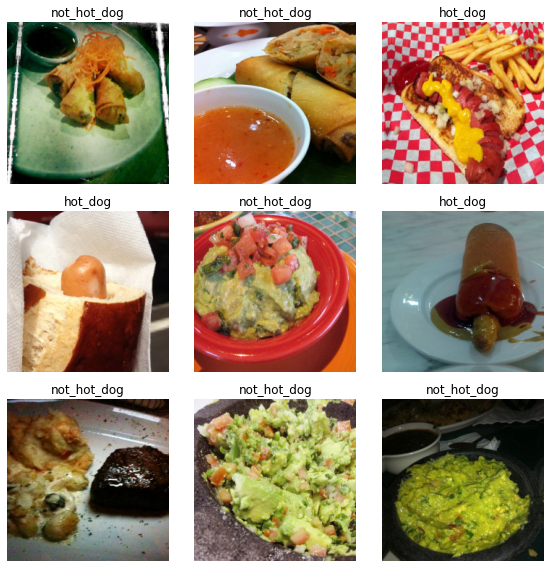

In [6]:
data.show_batch(rows=3, figsize=(8,8))

In [7]:
print(data.classes)
len(data.classes),data.c

['hot_dog', 'not_hot_dog']


(2, 2)

### Transfer Learning with Resnet34

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [9]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [10]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.797973,0.488477,0.166000,00:04
1,0.568517,0.607651,0.156000,00:03
2,0.471679,0.372291,0.114000,00:03
3,0.417580,0.360937,0.108000,00:03


In [11]:
learn.save('stage-1')

### Visualize Result

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

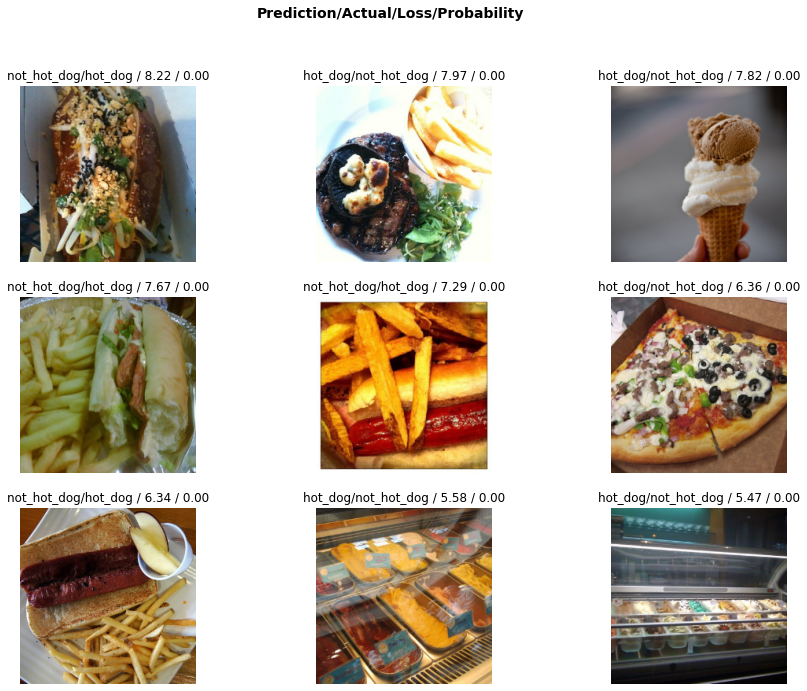

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

In [14]:
doc(interp.plot_top_losses)

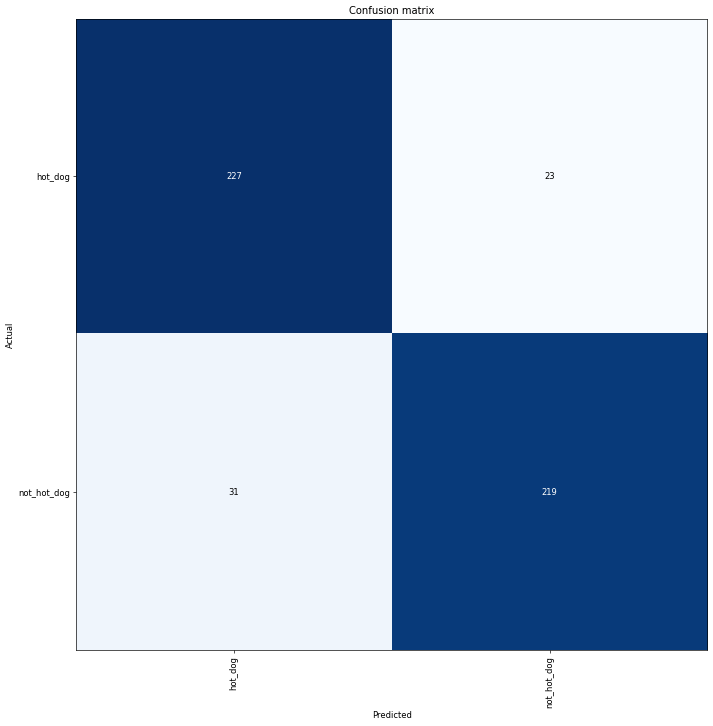

In [15]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [16]:
interp.most_confused(min_val=2)

[('not_hot_dog', 'hot_dog', 31), ('hot_dog', 'not_hot_dog', 23)]

### Unfreezing, fine-tuning, and learning rates

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.392499,0.565568,0.138000,00:04


In [19]:
learn.load('stage-1');

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


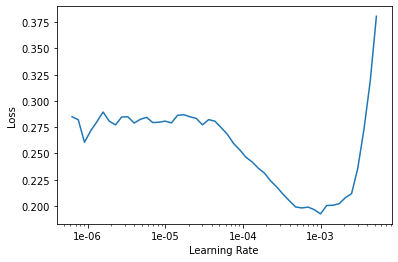

In [21]:
learn.recorder.plot()

In [22]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.246033,0.382247,0.120000,00:04
1,0.238124,0.393054,0.116000,00:04
2,0.219609,0.366099,0.100000,00:04
3,0.189501,0.351888,0.102000,00:04


In [23]:
learn.data.c2i

{'hot_dog': 0, 'not_hot_dog': 1}

In [24]:
images = get_image_files("./data/valid/hot_dog")

In [25]:
cat, tensor, probs = learn.predict(open_image(images[0]))

In [26]:
str(cat)

'hot_dog'